# IMPORTS AND CONFIG

In [1]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications import Xception

In [2]:
# Check if there are GPUs available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Check which GPU is being used (if any)
print("Available GPUs:")
for device in tf.config.experimental.list_physical_devices('GPU'):
    print(device.name)

GPU is available
Available GPUs:
/physical_device:GPU:0


# USING PRE-TRAINED MODEL(YOLOV8L-face) FOR FACE-DETECTION

In [3]:
from ultralytics import YOLO
yolomodel=YOLO('yolov8l-face.pt')

### Checking if YOLOv8l-face is working

In [4]:
image_path = r'C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\DETECTION_IMAGES\images\maksssksksss3.png'
results=yolomodel(image_path)[0]


image 1/1 C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\DETECTION_IMAGES\images\maksssksksss3.png: 672x960 11 faces, 997.9ms
Speed: 5.6ms preprocess, 997.9ms inference, 1.5ms postprocess per image at shape (1, 3, 672, 960)


In [5]:
# Extracting the bounding box coordinates
boxes = results.boxes.xyxy if hasattr(results.boxes, 'xyxy') else None

image = cv2.imread(results.path)
if boxes is not None:
    for box in boxes:
        x, y, x_max, y_max = map(int, box)

        color = (0, 255, 0) 
        cv2.rectangle(image, (x, y), (x_max, y_max), color, 2)

    cv2.imshow('Object Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No bounding box information found in the result.")

# TRANSFER LEARNING FOR FACE-MASK-DETECTION USING Xception

In [ ]:
from keras import Sequential
from keras.layers import Flatten, Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision,Recall,AUC

## MODEL TRAINING

In [ ]:
#Load train and test set
train_dir = r'C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Face Mask Dataset\Train'
test_dir = r'C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Face Mask Dataset\Test'
val_dir = r'C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\Face Mask Dataset\Validation'

In [ ]:
# hyper-parameters
Batch_size=32
learning_rate=1e-4
Epochs=20

In [ ]:
#  Data Argumentaors
train_datagen=ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.2,
        horizontal_flip=True,
        validation_split=0.20)
test_val_datagen=ImageDataGenerator(
    rescale=1.0/255
)

In [ ]:
# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=Batch_size
    )
val_generator = test_val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=Batch_size
    )

test_generator = test_val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=Batch_size
    )

In [ ]:
Xception_model = Xception(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in Xception_model.layers[:-5]:
    layer.trainable = False
    
model = Sequential()
model.add(Xception_model)
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2,activation='softmax'))
model.summary()


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy', Precision(), Recall(), AUC()])

In [ ]:
history = model.fit_generator(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples // Batch_size,   
                    validation_steps=val_generator.samples // Batch_size,
                    epochs=Epochs,  
                    verbose=2,
                    )

In [ ]:
df=pd.DataFrame(history.history)
df.to_csv('face-mask.csv',index=False)

In [ ]:
model.save('face_mask2.h5')

# EVALUATION AND PREDICTION  

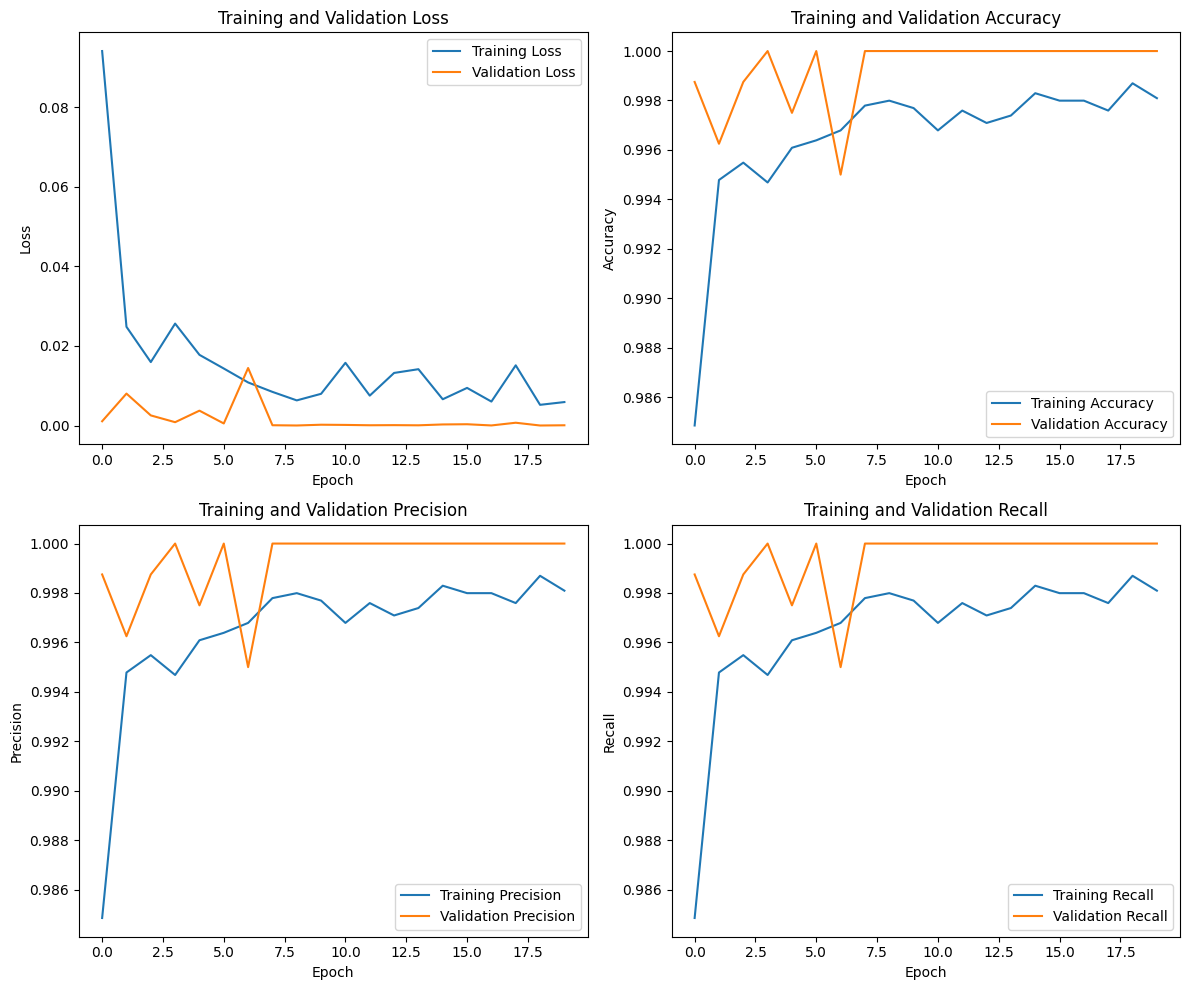

In [6]:
df=pd.read_csv('face-mask.csv')

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# training and validation loss
axes[0, 0].plot(df['loss'], label='Training Loss')
axes[0, 0].plot(df['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

#  training and validation accuracy
axes[0, 1].plot(df['accuracy'], label='Training Accuracy')
axes[0, 1].plot(df['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

#training and validation precision
axes[1, 0].plot(df['precision'], label='Training Precision')
axes[1, 0].plot(df['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Training and Validation Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# training and validation recall
axes[1, 1].plot(df['recall'], label='Training Recall')
axes[1, 1].plot(df['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Training and Validation Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()

plt.show()


In [6]:
class FaceDetection:
    def __init__(self, capture_index,mask_model):
        self.capture_index = capture_index
        self.mask_model=mask_model
        self.model = self.load_model()
    def load_model(self):
        model = YOLO('yolov8l-face.pt')
        model.fuse()
        return model

    def detect(self, frame):
        resized_frame = cv2.resize(frame, (640, 480))
        results = self.model(resized_frame)[0]
        return results

    def plot_bboxes(self, results, frame):
        face_roi = frame  # Initialize face_roi to the entire frame
        x, y, x_max, y_max = 0, 0, 0, 0  # Initialize bounding box coordinates
        for result in results.boxes.xyxy:
            #processing individually
            x, y, x_max, y_max = map(int, result.cpu().numpy()[:4])
            frame = cv2.rectangle(frame, (x, y), (x_max, y_max), (0, 255, 0), 2)

            face_roi = frame[y:y_max, x:x_max]
            #resizing
            resized_frame = cv2.resize(face_roi, (128, 128))
            normalized_frame = resized_frame / 255.0
            input_frame = np.expand_dims(normalized_frame, axis=0)
            
            # Predict using the face_mask_model
            predictions = self.mask_model.predict(input_frame)
            probability_with_mask = predictions[0, 0]

            label = 'With Mask' if probability_with_mask >= 0.5 else 'Without Mask'
            color = (0, 255, 0) if label == 'With Mask' else (0, 0, 255)

            cv2.rectangle(frame, (x, y), (x_max, y_max), color, 2)
            cv2.putText(frame, f'{label} ({probability_with_mask:.2f})', (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
        return frame

    def __call__(self):
        cap = cv2.VideoCapture(self.capture_index)
        assert cap.isOpened()

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            results = self.detect(frame)
            frame=self.plot_bboxes(results,frame)
            
            cv2.imshow('Face Mask and YOLOv8 Detection', frame)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()


if __name__ == "__main__":
    face_mask_model = tf.keras.models.load_model('face_mask2.h5')
    capture_index = 0  
    face_detector = FaceDetection(capture_index,face_mask_model)
    face_detector()

Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs

0: 736x960 2 faces, 1035.4ms
Speed: 9.0ms preprocess, 1035.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 960)
1/1 [==============================] - 0s 22ms/step

0: 736x960 2 faces, 988.7ms
Speed: 7.0ms preprocess, 988.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 960)
1/1 [==============================] - 0s 20ms/step

0: 736x960 2 faces, 1029.3ms
Speed: 4.0ms preprocess, 1029.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 960)
1/1 [==============================] - 0s 22ms/step

0: 736x960 2 faces, 978.7ms
Speed: 6.0ms preprocess, 978.7ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 960)
1/1 [==============================] - 0s 24ms/step

0: 736x960 2 faces, 1000.4ms
Speed: 8.0ms preprocess, 1000.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 960)
1/1 [==============================] - 0s 22ms/step

0: 736x960 2 fac

In [12]:
image_path = r'C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\DETECTION_IMAGES\images\maksssksksss5.png'
results=yolomodel(image_path)[0]
boxes = results.boxes.xyxy if hasattr(results.boxes, 'xyxy') else None

image = cv2.imread(results.path)
if boxes is not None:
    for box in boxes:
        x, y, x_max, y_max = map(int, box)
        color = (0, 255, 0) 
        im=cv2.rectangle(image, (x, y), (x_max, y_max), color, 2)
        face_roi= im[y:y_max, x:x_max]
        
        resized_frame = cv2.resize(face_roi, (128, 128))
        normalized_frame = resized_frame / 255.0
        input_frame = np.expand_dims(normalized_frame, axis=0)
        
        # Predict using the face_mask_model
        predictions = face_mask_model.predict(input_frame)
        probability_with_mask = predictions[0, 0]

        label = 'With Mask' if probability_with_mask >= 0.5 else 'Without Mask'
        color = (0, 255, 0) if label == 'With Mask' else (0, 0, 255)

        cv2.rectangle(im, (x, y), (x_max, y_max), color, 2)
        cv2.putText(im, f'{label} ({probability_with_mask:.2f})', (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

        cv2.imshow('Object Detection', image)
        
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No bounding box information found in the result.")


image 1/1 C:\Users\arpit\Desktop\SAP-internal-face-mask-detection\DETECTION_IMAGES\images\maksssksksss5.png: 640x960 5 faces, 880.6ms
Speed: 5.0ms preprocess, 880.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 960)
1/1 [==============================] - 0s 36ms/step
